In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color='white', max_words=10).generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud


def preprocess_data(data):
    data = data.replace('?', np.NaN)

    # Drop unnecessary columns
    # weights, payer_code, diag_1_desc, diag_2_desc, diag_3_desc
    data.drop(labels=['weight', 'payer_code', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc'], axis=1, inplace=True)

    data['diag_1'] = group_diagnoses(data['diag_1'])
    data['diag_2'] = group_diagnoses(data['diag_2'])
    data['diag_3'] = group_diagnoses(data['diag_3'])

    # Encode string data to numericals
    to_cat = list(data.select_dtypes(['object']).columns)
    data[to_cat] = data[to_cat].astype('category')
    cat_columns = data.select_dtypes(['category']).columns
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)

    # Get Readmitted as labels
    labels = data['readmitted']
    data.drop(labels=['readmitted'], axis=1, inplace=True)
    return labels.values.ravel(), data


def preprocess_text(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    text = [w for w in word_tokens if not w in stop_words]
    text = ' '.join(text)
    return WordNetLemmatizer().lemmatize(text)

def process_text(data_org, column_name):
    text = data_org[column_name]
    text = text.replace(np.NaN, '')
    text = text.values
    labels = data_org['readmitted']
    
    indices_readmitted = np.where(labels == 0)[0]
    indices_not_readmitted = np.where(labels == 1)[0]
    
    text_readmitted = text[indices_readmitted]
    text_not_readmitted = text[indices_not_readmitted]
    text_readmitted = ' '.join(text_readmitted)
    text_not_readmitted = ' '.join(text_not_readmitted)
    
    return text_readmitted, text_not_readmitted



def group_diagnoses(df):
    # Create mapping from
    l_old = []
    l_new = []

    idx = 0
    tmp_list1 = list(range(390, 460))
    tmp_list1 += [785]
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1

    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = list(range(460, 520))
    tmp_list1 += [786]
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1

    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = list(range(520, 579))
    tmp_list1 += [787]
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1

    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = [str(i) for i in list(np.arange(250, 251, 0.01))]
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1
    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = range(800, 1000)
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1
    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = range(710, 740)
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1
    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = list(range(580, 630))
    tmp_list1 += [788]
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1
    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    tmp_list1 = range(140, 240)
    tmp_list2 = [idx] * len(tmp_list1)
    idx += 1
    l_old = [*l_old, *tmp_list1]
    l_new = [*l_new, *tmp_list2]

    l_old = [str(i) for i in l_old]
    d = dict(zip(l_old, l_new))

    df_new = df.copy()

    df_new = df_new.map(d)
    df_new = df_new.replace(df_new[pd.isna(df_new)], 8)
    df_new = df_new.astype(int)
    return df_new


data_train = pd.read_csv('task1/data/diab_train.csv', index_col=0)
data_test = pd.read_csv('task1/data/diab_test.csv', index_col=0)
data_validation = pd.read_csv('task1/data/diab_validation.csv', index_col=0)
data = pd.concat([data_train, data_validation, data_test], axis=0)
data.reset_index(drop=True, inplace=True)
data_original = data.copy()
labels, data = preprocess_data(data)
    


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


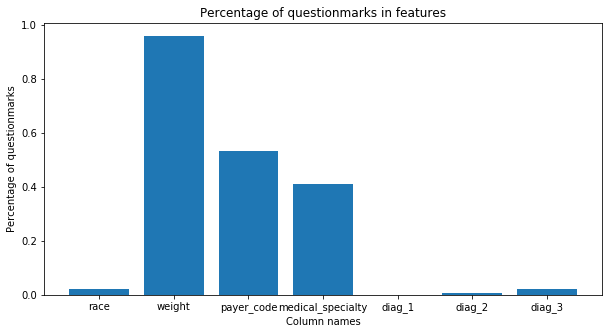

In [2]:
values = []
col_names = []
for col in data_original:
    if '?' in data_original[col].value_counts().index:
        col_names.append(col)
        tot = data_original[col].value_counts().sum()
        idx = data_original[col].value_counts().index.get_loc('?')
        num = data_original[col].value_counts().iloc[idx]
        values.append(num/tot)
        
fig = plt.figure(figsize=(10,5))
plt.title('Percentage of questionmarks in features')
plt.bar(col_names,values)
plt.xlabel("Column names")
plt.ylabel("Percentage of questionmarks")
plt.savefig('missing_values.png')
plt.show()



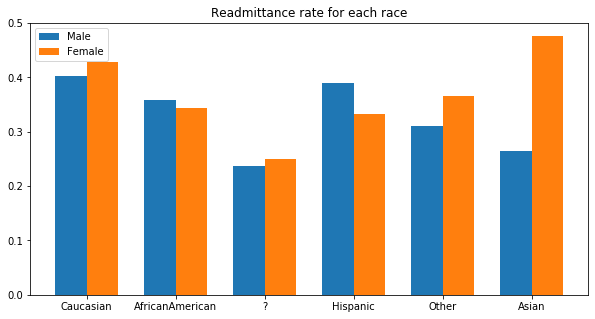

In [3]:
values_men = []
values_women = []
race_list = data_original['race'].value_counts().index
for race in race_list:
    df_tmp = data_original[data_original['race'] == race]
    
    df_readmitted = df_tmp[df_tmp['readmitted'] == 1]
    df_notreadmitted = df_tmp[df_tmp['readmitted'] == 0]
    
    not_read_f = df_notreadmitted['gender'].value_counts().loc['Female']
    not_read_m = df_notreadmitted['gender'].value_counts().loc['Male']
    read_f = df_readmitted['gender'].value_counts().loc['Female']
    read_m = df_readmitted['gender'].value_counts().loc['Male']
    
    values_men.append(read_m/(read_m+not_read_m))
    values_women.append(read_f/(read_f+not_read_f))
    
    
fig = plt.figure(figsize=(10,5))
plt.title('Readmittance rate for each race')
width = 0.35   
ind = np.arange(6) 
plt.bar(ind, values_men, width, label='Male')
plt.bar(ind+width, values_women, width,
    label='Female')

plt.xticks(ind + width / 2, (list(race_list)))
plt.legend(loc='best')
plt.savefig('readmittance_rates.png')
plt.show()

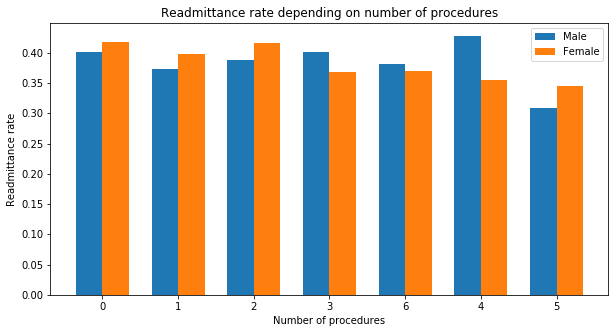

In [4]:
values_men = []
values_women = []
index_list = data_original['num_procedures'].value_counts().index
for val in index_list:

    df_tmp = data_original[data_original['num_procedures'] == val]

    df_readmitted = df_tmp[df_tmp['readmitted'] == 1]
    df_notreadmitted = df_tmp[df_tmp['readmitted'] == 0]

    not_read_f = df_notreadmitted['gender'].value_counts().loc['Female']
    not_read_m = df_notreadmitted['gender'].value_counts().loc['Male']
    read_f = df_readmitted['gender'].value_counts().loc['Female']
    read_m = df_readmitted['gender'].value_counts().loc['Male']

    values_men.append(read_m/(read_m+not_read_m))
    values_women.append(read_f/(read_f+not_read_f))


fig = plt.figure(figsize=(10,5))
plt.title('Readmittance rate depending on number of procedures')
width = 0.35   
ind = np.arange(len(index_list)) 
plt.bar(ind, values_men, width, label='Male')
plt.bar(ind+width, values_women, width,
label='Female')
plt.xlabel("Number of procedures")
plt.ylabel("Readmittance rate")
plt.xticks(ind + width / 2, (list(index_list)))
plt.legend(loc='best')
plt.show()

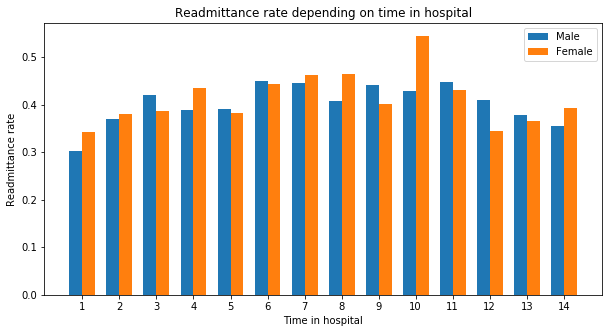

In [5]:
values_men = []
values_women = []
index_list = list(data_original['time_in_hospital'].value_counts().index)
index_list.sort()
for val in index_list:

    df_tmp = data_original[data_original['time_in_hospital'] == val]

    df_readmitted = df_tmp[df_tmp['readmitted'] == 1]
    df_notreadmitted = df_tmp[df_tmp['readmitted'] == 0]

    not_read_f = df_notreadmitted['gender'].value_counts().loc['Female']
    not_read_m = df_notreadmitted['gender'].value_counts().loc['Male']
    read_f = df_readmitted['gender'].value_counts().loc['Female']
    read_m = df_readmitted['gender'].value_counts().loc['Male']

    values_men.append(read_m/(read_m+not_read_m))
    values_women.append(read_f/(read_f+not_read_f))


fig = plt.figure(figsize=(10,5))
plt.title('Readmittance rate depending on time in hospital')
width = 0.35   
ind = np.arange(len(index_list)) 
plt.bar(ind, values_men, width, label='Male')
plt.bar(ind+width, values_women, width,
label='Female')
plt.xlabel("Time in hospital")
plt.ylabel("Readmittance rate")
plt.xticks(ind + width / 2, (list(index_list)))
plt.legend(loc='best')
plt.show()

diag_1_desc
Readmitted


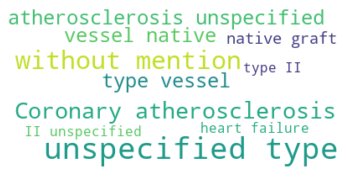

NOT Readmitted


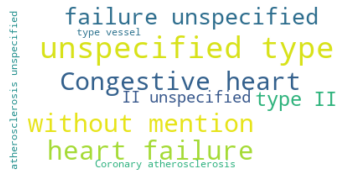


diag_2_desc
Readmitted


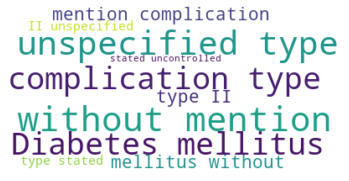

NOT Readmitted


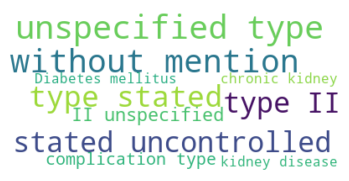


diag_3_desc
Readmitted


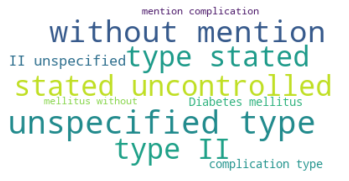

NOT Readmitted


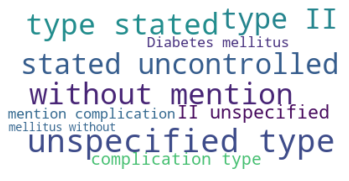

In [6]:
names = ['diag_1_desc', 'diag_2_desc', 'diag_3_desc']

for diag in names:
    print(diag)
    text_readmitted, text_not_readmitted = process_text(data_original, diag)
    print('Readmitted')
    wc_readmitted = plot_wordcloud(text_readmitted)
    wc_readmitted.to_file(diag + '_' + 'readmitted.png')
    print('NOT Readmitted')
    wc_not_readmitted = plot_wordcloud(text_not_readmitted)
    wc_not_readmitted.to_file(diag + '_' + 'not_readmitted.png')
    print()

In [7]:
data.shape

(10000, 45)

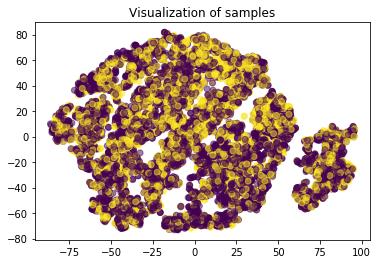

In [8]:
### Plot data with tSNE

import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(data)
X_embedded.shape

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data_original['readmitted'].values, alpha=0.5)
plt.title('Visualization of samples')
#plt.legend(loc=2)

#plt.xlabel('x')
#plt.ylabel('y')
plt.savefig('tsne2d_vis.png')
plt.show()


In [9]:
### do tSNE on textual data features
textdata = data_original['diag_1_desc']
textdata = textdata.replace(np.NaN, '').values

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, preprocessor=preprocess_text)
text_features = vectorizer.fit_transform(textdata)
text_features = pd.DataFrame.sparse.from_spmatrix(text_features).values

print(text_features)

text_features = text_features.reshape(10000,-1)
print(text_features.shape)




C:\Users\berka\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 863)


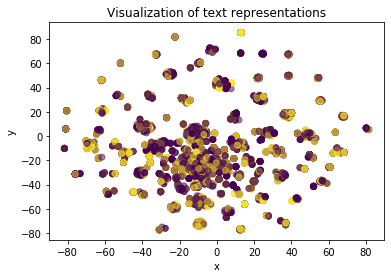

In [10]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(text_features)
X_embedded.shape

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data_original['readmitted'].values, alpha=0.5)
plt.title('Visualization of text representations')
#plt.legend(loc=2)

plt.xlabel('x')
plt.ylabel('y')
plt.savefig('tsne2d_text.png')
plt.show()
